In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFBertModel
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
class ClassifierModel():
    def __init__(self, model_name):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
    
        self.preprocess()
        
        self.model = self.set_model()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=4)
        
    
    def data_load(self):
        
        _dir = '../../data'
        
        trains = []
        vals = []
        tests = []
        
        datasets = [
            { 'name': 'preprocessed_train', 'frac': 1 },
            { 'name': 'train_rs', 'frac': 0.4 },
            { 'name': 'train_rd', 'frac': 0.35 }
        ]
        
        for it in datasets:
            _df = pd.read_csv(f'{_dir}/{it["name"]}.csv')
            
            _train = _df[:int(len(_df)*0.6)]
            _val = _df[int(len(_df)*0.6):int(len(_df)*0.8)]
            _test = _df[int(len(_df)*0.8):]
            
            if it["name"] == 'preprocessed_train':
                vals.append(_val)
                tests.append(_test)
            else:
                _train = _train.sample(frac=it['frac'])
                
            trains.append(_train)
            
        train = pd.concat(trains)
        train.drop_duplicates(inplace=True)
        val = pd.concat(vals)
        val.drop_duplicates(inplace=True)
        test = pd.concat(tests)
        test.drop_duplicates(inplace=True)
        
        return train, val, test
    
    
    def cls_embedding(self, data):
        for it in tqdm(data):
            inputs = self.tokenizer(it, return_tensors='tf', truncation=True)
            outputs = self.bert(inputs)
            cls_embeddings = outputs.last_hidden_state[:,0]
            yield cls_embeddings 
    
    
    def preprocess(self):
        
        train, val, test = self.data_load()
        
        train_cls_emb = list(self.cls_embedding(train['data']))
        self.x_train = pd.DataFrame(np.squeeze(np.array(train_cls_emb), axis=1))
        self.y_train = tf.keras.utils.to_categorical(train['label'], num_classes=4, dtype='float32')
        
        val_cls_emb = list(self.cls_embedding(val['data']))
        self.x_val = pd.DataFrame(np.squeeze(np.array(val_cls_emb), axis=1))
        self.y_val = tf.keras.utils.to_categorical(val['label'], num_classes=4, dtype='float32')
        
        test_cls_emb = list(self.cls_embedding(test['data']))
        self.x_test = pd.DataFrame(np.squeeze(np.array(test_cls_emb), axis=1))
        self.y_test = tf.keras.utils.to_categorical(test['label'], num_classes=4, dtype='float32')
        
    
    def set_model(self):
    
        inputs = Input(shape=(None, self.x_train.shape[1]))
        out = Dense(32, activation='relu')(inputs)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
                
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/20
65/65 [==============================] - 1s 5ms/step - loss: 1.1470 - accuracy: 0.4990 - val_loss: 0.7560 - val_accuracy: 0.7127
Epoch 2/20
65/65 [==============================] - 0s 3ms/step - loss: 0.8429 - accuracy: 0.6596 - val_loss: 0.6357 - val_accuracy: 0.7658
Epoch 3/20
65/65 [==============================] - 0s 3ms/step - loss: 0.7340 - accuracy: 0.7088 - val_loss: 0.5473 - val_accuracy: 0.7899
Epoch 4/20
65/65 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.7336 - val_loss: 0.5554 - val_accuracy: 0.7937
Epoch 5/20
65/65 [==============================] - 0s 3ms/step - loss: 0.6456 - accuracy: 0.7555 - val_loss: 0.4963 - val_accuracy: 0.8025
Epoch 6/20
65/65 [==============================] - 0s 3ms/step - loss: 0.6283 - accuracy: 0.7543 - val_loss: 0.5027 - val_accuracy: 0.8089
Epoch 7/20
65/65 [==============================] - 0s 3ms/step - loss: 0.5808 - accuracy: 0.7719 - val_loss: 0.4846 - val_accuracy: 0.8190
Epoch 8/20
65/65 [==

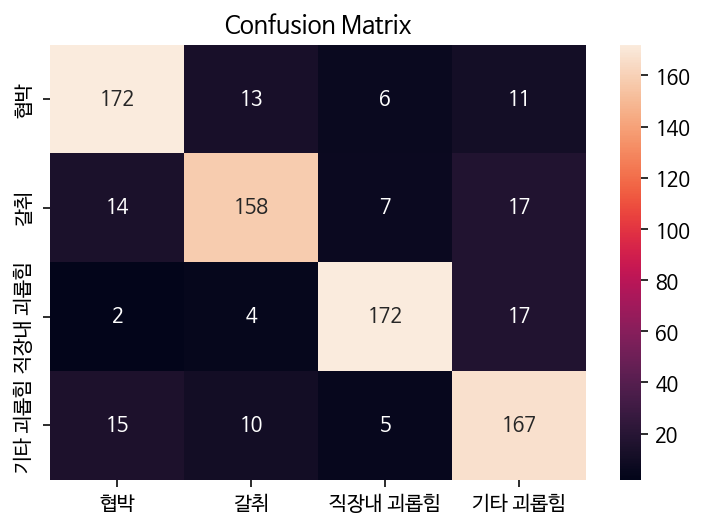

In [15]:
model = ClassifierModel('klue/bert-base')
model.train()
model.show_report()

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/20
65/65 [==============================] - 1s 5ms/step - loss: 1.2202 - accuracy: 0.4530 - val_loss: 0.7651 - val_accuracy: 0.7278
Epoch 2/20
65/65 [==============================] - 0s 3ms/step - loss: 0.8188 - accuracy: 0.6630 - val_loss: 0.5772 - val_accuracy: 0.7861
Epoch 3/20
65/65 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.7273 - val_loss: 0.5444 - val_accuracy: 0.8177
Epoch 4/20
65/65 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.7560 - val_loss: 0.5250 - val_accuracy: 0.8165
Epoch 5/20
65/65 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.7640 - val_loss: 0.5163 - val_accuracy: 0.8000
Epoch 6/20
65/65 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7881 - val_loss: 0.4717 - val_accuracy: 0.8316
Epoch 7/20
65/65 [==============================] - 0s 3ms/step - loss: 0.5577 - accuracy: 0.7869 - val_loss: 0.4685 - val_accuracy: 0.8354
Epoch 8/20
65/65 [==

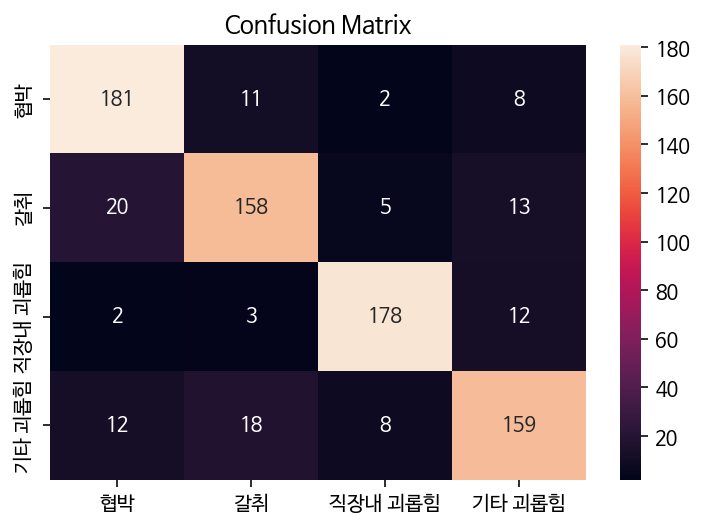

In [16]:
model = ClassifierModel('beomi/kcbert-base')
model.train()
model.show_report()

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/514 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/124 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['electra.encoder.layer.2.attention.output.LayerNorm.bias', 'electra.encoder.layer.11.attention.self.query.weight', 'electra.encoder.layer.4.attention.output.dense.bias', 'electra.encoder.layer.3.output.dense.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.5.intermediate.dense.weight', 'electra.encoder.layer.10.attention.self.value.bias', 'electra.encoder.layer.7.attention.self.value.bias', 'electra.encoder.layer.3.attention.self.key.weight', 'electra.encoder.layer.5.attention.self.query.bias', 'electra.encoder.layer.1.attention.self.key.weight', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.5.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.10.attention.self.query.weight', 'electra.encoder.layer.9.attention.self.key.bias', 'electra.encoder.layer.6.output.LayerNorm.weig

Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.lay

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/20
65/65 [==============================] - 1s 5ms/step - loss: 1.4073 - accuracy: 0.2907 - val_loss: 1.3671 - val_accuracy: 0.3025
Epoch 2/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3605 - accuracy: 0.3067 - val_loss: 1.3425 - val_accuracy: 0.3570
Epoch 3/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3454 - accuracy: 0.3259 - val_loss: 1.3188 - val_accuracy: 0.3747
Epoch 4/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3312 - accuracy: 0.3308 - val_loss: 1.3105 - val_accuracy: 0.3823
Epoch 5/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3306 - accuracy: 0.3390 - val_loss: 1.3040 - val_accuracy: 0.3886
Epoch 6/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3227 - accuracy: 0.3462 - val_loss: 1.2864 - val_accuracy: 0.3975
Epoch 7/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3135 - accuracy: 0.3491 - val_loss: 1.2840 - val_accuracy: 0.3987
Epoch 8/20
65/65 [==

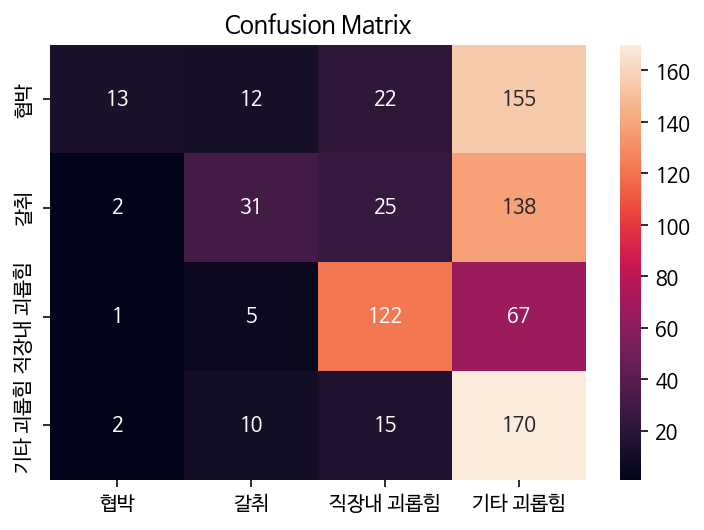

In [17]:
model = ClassifierModel('beomi/KcELECTRA-base')
model.train()
model.show_report()

Downloading:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['electra.encoder.layer.2.attention.output.LayerNorm.bias', 'electra.encoder.layer.11.attention.self.query.weight', 'electra.encoder.layer.4.attention.output.dense.bias', 'electra.encoder.layer.3.output.dense.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.5.intermediate.dense.weight', 'electra.encoder.layer.10.attention.self.value.bias', 'electra.encoder.layer.7.attention.self.value.bias', 'electra.encoder.layer.3.attention.self.key.weight', 'electra.encoder.layer.5.attention.self.query.bias', 'electra.encoder.layer.1.attention.self.key.weight', 'electra.encoder.layer.4.attention.output.dense.weight', 'electra.encoder.layer.5.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.10.attention.self.query.weight', 'electra.encoder.layer.9.attention.self.key.bias', 'electra.encoder.layer.6.output.LayerNorm.weig

Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.lay

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/20
65/65 [==============================] - 1s 5ms/step - loss: 1.4263 - accuracy: 0.2657 - val_loss: 1.3848 - val_accuracy: 0.2911
Epoch 2/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3850 - accuracy: 0.2818 - val_loss: 1.3834 - val_accuracy: 0.2911
Epoch 3/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3843 - accuracy: 0.2830 - val_loss: 1.3822 - val_accuracy: 0.2911
Epoch 4/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3838 - accuracy: 0.2818 - val_loss: 1.3812 - val_accuracy: 0.2911
Epoch 5/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3835 - accuracy: 0.2818 - val_loss: 1.3807 - val_accuracy: 0.2911
Epoch 6/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3832 - accuracy: 0.2818 - val_loss: 1.3802 - val_accuracy: 0.2911
Epoch 7/20
65/65 [==============================] - 0s 3ms/step - loss: 1.3831 - accuracy: 0.2818 - val_loss: 1.3799 - val_accuracy: 0.2911
Epoch 8/20
65/65 [==

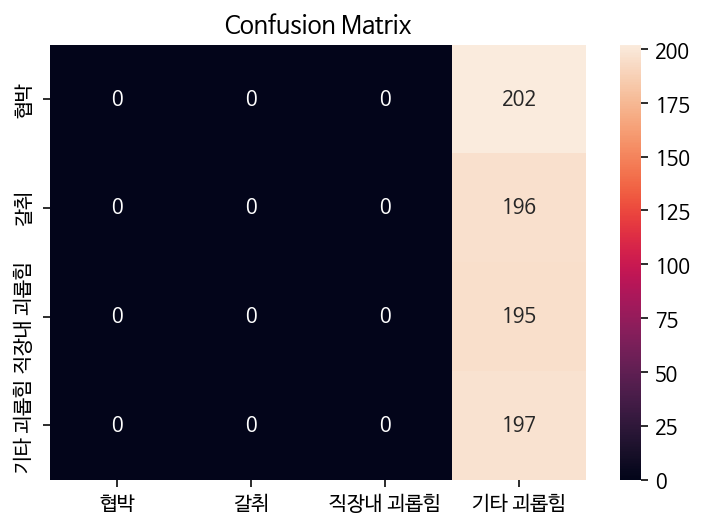

In [18]:
model = ClassifierModel('tunib/electra-ko-base')
model.train()
model.show_report()

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['roberta.encoder.layer.20.attention.output.LayerNorm.weight', 'roberta.encoder.layer.17.attention.output.LayerNorm.weight', 'roberta.encoder.layer.8.intermediate.dense.bias', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.8.attention.output.LayerNorm.weight', 'roberta.encoder.layer.10.attention.self.key.weight', 'roberta.encoder.layer.20.attention.self.value.weight', 'roberta.encoder.layer.23.attention.output.dense.weight', 'roberta.encoder.layer.8.attention.output.dense.weight', 'roberta.encoder.layer.4.attention.self.key.bias', 'roberta.encoder.layer.16.output.dense.weight', 'roberta.encoder.layer.14.attention.output.LayerNorm.bias', 'roberta.encoder.layer.5.output.LayerNorm.bias', 'roberta.encoder.layer.10.output.LayerNorm.bias', 'roberta.embeddings.position_embeddings.weight', 'roberta.encoder.layer.18.attention.self.value.weight', 'roberta.encoder.layer.3.att

Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.lay

  0%|          | 0/4148 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/790 [00:00<?, ?it/s]

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f2d9c2fdca0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f2

accuracy : 0.24936708860759493
macro f1 : 0.09979736575481256
weighted f1 : 0.09954471419593962


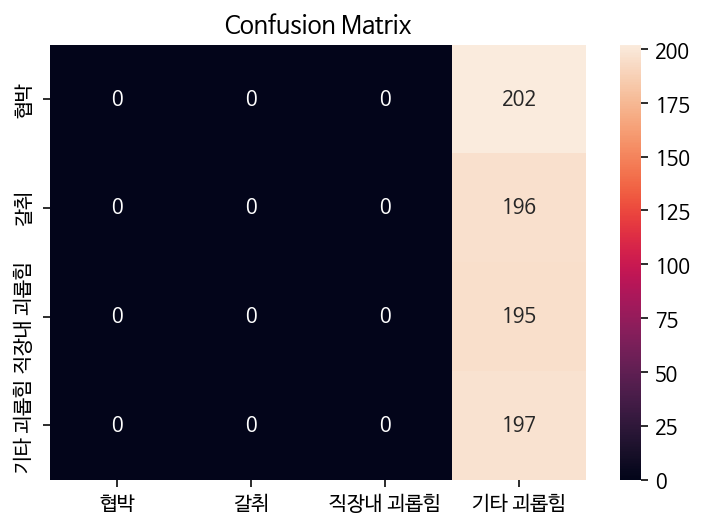

In [4]:
model = ClassifierModel('klue/roberta-large')
model.train()
model.show_report()